# Wikipedia Text Generation (using RNN LSTM)

## Import dependencies

In [1]:
!pip install keras==2.2.4
!pip install tensorflow==2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.5/312.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.2.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.10.12
Tensorflow version: 2.8.0
Keras version: 2.8.0


In [4]:
# Loading the wikipedia dataset.
DATASET_NAME = 'wikipedia/20190301.en'

dataset, dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    split=tfds.Split.TRAIN,
)

Dl Completed...:   0%|          | 0/258 [00:00<?, ? file/s]

Dataset wikipedia downloaded and prepared to tmp/wikipedia/20190301.en/1.0.0. Subsequent calls will reuse this data.


In [5]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='wikipedia',
    full_name='wikipedia/20190301.en/1.0.0',
    description="""
    Wikipedia dataset containing cleaned articles of all languages.
    The datasets are built from the Wikipedia dump
    (https://dumps.wikimedia.org/) with one split per language. Each example
    contains the content of one full Wikipedia article with cleaning to strip
    markdown and unwanted sections (references, etc.).
    """,
    config_description="""
    Wikipedia dataset for en, parsed from 20190301 dump.
    """,
    homepage='https://dumps.wikimedia.org',
    data_dir='tmp/wikipedia/20190301.en/incomplete.YRKYQ9_1.0.0/',
    file_format=tfrecord,
    download_size=15.72 GiB,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'text': Text(shape=(), dtype=string),
        'title': Text(shape=(), dtype=string),
    }),
    supervised_keys=None,
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=5824596, num_shards=256>

In [6]:
print(dataset)

<PrefetchDataset element_spec={'text': TensorSpec(shape=(), dtype=tf.string, name=None), 'title': TensorSpec(shape=(), dtype=tf.string, name=None)}>


## Analyze the dataset

In [7]:
TRAIN_NUM_EXAMPLES = dataset_info.splits['train'].num_examples
print('Total number of articles: ', TRAIN_NUM_EXAMPLES)

Total number of articles:  5824596


In [8]:
print('First article','\n======\n')
for example in dataset.take(1):
    print('Title:','\n------')
    print(example['title'].numpy().decode('utf-8'))
    print()

    print('Text:', '\n------')
    print(example['text'].numpy().decode('utf-8'))

First article 

Title: 
------
Joseph Greenberg

Text: 
------
Joseph Harold Greenberg (May 28, 1915 – May 7, 2001) was an American linguist, known mainly for his work concerning linguistic typology and the genetic classification of languages.

Life

Early life and education 
(Main source: Croft 2003)

Joseph Greenberg was born on May 28, 1915 to Jewish parents in Brooklyn, New York. His first great interest was music. At the age of 14, he gave a piano concert in Steinway Hall. He continued to play the piano frequently throughout his life.

After finishing high school, he decided to pursue a scholarly career rather than a musical one. He enrolled at Columbia University in New York. During his senior year, he attended a class taught by Franz Boas concerning American Indian languages. With references from Boas and Ruth Benedict, he was accepted as a graduate student by Melville J. Herskovits at Northwestern University in Chicago. During the course of his graduate studies, Greenberg did f

## Process the dataset

### Flatten the dataset

Converting the dataset from the set of articles into the set of characters. We also are interested only in `text` of each article so we may drop the `title` along the way.

In [9]:
def article_to_text(text):
    return np.array([char for char in text.numpy().decode('utf-8')])

# Converting each dataset item to a string ('text') instead of a dictionary ({'text', 'title'}).
dataset_text = dataset.map(
    lambda article: tf.py_function(func=article_to_text, inp=[article['text']], Tout=tf.string)
)

for text in dataset_text.take(2):
    print(text.numpy())
    print('\n')

[b'J' b'o' b's' ... b'n' b't' b's']


[b'P' b'a' b'u' ... b'e' b'r' b's']




In [10]:
# Unbatch the text dataset into a more granular char dataset.
# Now each dataset item is one character instead of a big piece of text.
dataset_chars = dataset_text.unbatch()

for char in dataset_chars.take(20):
    print(char.numpy().decode('utf-8'))

J
o
s
e
p
h
 
H
a
r
o
l
d
 
G
r
e
e
n
b


### Generating vocabulary

In [11]:
vocab = set()

# Ideally we should take all dataset items into account here.
for text in dataset_text.take(1000):
    vocab.update([char.decode('utf-8') for char in text.numpy()])

vocab = sorted(vocab)

print('Unique characters: {}'.format(len(vocab)))
print('vocab:')
print(vocab)

Unique characters: 621
vocab:
['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\xa0', '£', '§', '«', '®', '°', '±', '²', '·', '»', '¼', '½', '¿', 'Á', 'Å', 'Æ', 'Ç', 'É', 'Ë', 'Í', 'Î', 'Ó', 'Ö', '×', 'Ø', 'Ü', 'Þ', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'ú', 'û', 'ü', 'ý', 'ā', 'ă', 'ą', 'Ć', 'ć', 'Č', 'č', 'đ', 'ė', 'ę', 'ě', 'ğ', 'ġ', 'Ħ', 'ī', 'İ', 'ı', 'ļ', 'Ł', 'ł', 'ń', 'ň', 'Ō', 'ō', 'ő', 'ř', 'Ś', 'ś', 'Ş', 'ş', 'Š', 'š', 'ţ', 'ū', 'ź', 'ż', 'Ž', 'ž', 'ơ', 'ư', 'ǔ', 'ș',

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [12]:
# Map characters to their indices in vocabulary.
char2index = {char: index for index, char in enumerate(vocab)}

print('{')
for char, _ in zip(char2index, range(30)):
    print('  {:4s}: {:3d},'.format(repr(char), char2index[char]))
print('  ...\n}')

{
  '\t':   0,
  '\n':   1,
  ' ' :   2,
  '!' :   3,
  '"' :   4,
  '#' :   5,
  '$' :   6,
  '%' :   7,
  '&' :   8,
  "'" :   9,
  '(' :  10,
  ')' :  11,
  '*' :  12,
  '+' :  13,
  ',' :  14,
  '-' :  15,
  '.' :  16,
  '/' :  17,
  '0' :  18,
  '1' :  19,
  '2' :  20,
  '3' :  21,
  '4' :  22,
  '5' :  23,
  '6' :  24,
  '7' :  25,
  '8' :  26,
  '9' :  27,
  ':' :  28,
  ';' :  29,
  ...
}


In [13]:
# Map character indices to characters from vacabulary.
index2char = np.array(vocab)

print(index2char)

['\t' '\n' ' ' '!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/'
 '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' '@' 'A'
 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S'
 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' '[' ']' '^' '_' '`' 'a' 'b' 'c' 'd' 'e' 'f'
 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x'
 'y' 'z' '{' '|' '}' '~' '\xa0' '£' '§' '«' '®' '°' '±' '²' '·' '»' '¼'
 '½' '¿' 'Á' 'Å' 'Æ' 'Ç' 'É' 'Ë' 'Í' 'Î' 'Ó' 'Ö' '×' 'Ø' 'Ü' 'Þ' 'ß' 'à'
 'á' 'â' 'ã' 'ä' 'å' 'æ' 'ç' 'è' 'é' 'ê' 'ë' 'ì' 'í' 'î' 'ï' 'ñ' 'ò' 'ó'
 'ô' 'õ' 'ö' 'ø' 'ú' 'û' 'ü' 'ý' 'ā' 'ă' 'ą' 'Ć' 'ć' 'Č' 'č' 'đ' 'ė' 'ę'
 'ě' 'ğ' 'ġ' 'Ħ' 'ī' 'İ' 'ı' 'ļ' 'Ł' 'ł' 'ń' 'ň' 'Ō' 'ō' 'ő' 'ř' 'Ś' 'ś'
 'Ş' 'ş' 'Š' 'š' 'ţ' 'ū' 'ź' 'ż' 'Ž' 'ž' 'ơ' 'ư' 'ǔ' 'ș' 'ț' 'ɔ' 'ə' 'ɛ'
 'ʷ' 'ʼ' 'ʿ' '˚' 'Ι' 'Π' 'α' 'β' 'ε' 'η' 'ι' 'κ' 'μ' 'ο' 'ρ' 'ς' 'τ' 'υ'
 'χ' 'ψ' 'ό' 'Б' 'В' 'Д' 'Ж' 'З' 'И' 'К' 'Л' 'М' 'Н' 'О' 'П' 'С' 'У' 'Ф'
 'Х' 'а' 'б' 'в' 'г' 'д' 'е' 'з' 'и' 'й' 'к' 'л' '

In [14]:
def char_to_index(char):
    char_symbol = char.numpy().decode('utf-8')
    char_index = char2index[char_symbol] if char_symbol in char2index else char2index['?']
    return char_index

dataset_chars_indexed = dataset_chars.map(
    lambda char: tf.py_function(func=char_to_index, inp=[char], Tout=tf.int32)
)

print('ORIGINAL CHARS:', '\n---')
for char in dataset_chars.take(10):
    print(char.numpy().decode())

print('\n\n')

print('INDEXED CHARS:', '\n---')
for char_index in dataset_chars_indexed.take(20):
    print(char_index.numpy())

ORIGINAL CHARS: 
---
J
o
s
e
p
h
 
H
a
r



INDEXED CHARS: 
---
44
80
84
70
81
73
2
42
66
83
80
77
69
2
41
83
70
70
79
67


## Create training sequences

In [15]:
# The maximum length sentence we want for a single input in characters.
sequence_length = 200

In [16]:
# Generate batched sequences out of the char_dataset.
sequences = dataset_chars_indexed.batch(sequence_length + 1, drop_remainder=True)

# Sequences examples.
for item in sequences.take(10):
    print(repr(''.join(index2char[item.numpy()])))
    print()

'Joseph Harold Greenberg (May 28, 1915 – May 7, 2001) was an American linguist, known mainly for his work concerning linguistic typology and the genetic classification of languages.\n\nLife\n\nEarly life an'

'd education \n(Main source: Croft 2003)\n\nJoseph Greenberg was born on May 28, 1915 to Jewish parents in Brooklyn, New York. His first great interest was music. At the age of 14, he gave a piano concert '

'in Steinway Hall. He continued to play the piano frequently throughout his life.\n\nAfter finishing high school, he decided to pursue a scholarly career rather than a musical one. He enrolled at Columbia'

' University in New York. During his senior year, he attended a class taught by Franz Boas concerning American Indian languages. With references from Boas and Ruth Benedict, he was accepted as a graduat'

'e student by Melville J. Herskovits at Northwestern University in Chicago. During the course of his graduate studies, Greenberg did fieldwork among the Hausa people of Ni

In [17]:
# sequences shape:
# - Each sequence of length 101
#
#    201     201          201
# [(.....) (.....) ...  (.....)]

For each sequence, duplicate and shift it to form the input and target text. For example, say `sequence_length` is `4` and our text is `Hello`. The input sequence would be `Hell`, and the target sequence `ello`.

In [18]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [19]:
dataset_sequences = sequences.map(split_input_target)

In [20]:
for input_example, target_example in dataset_sequences.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    print('Input:\n', repr(''.join(index2char[input_example.numpy()])))
    print()
    print('Target:\n', repr(''.join(index2char[target_example.numpy()])))

Input sequence size: 200
Target sequence size: 200

Input:
 'Joseph Harold Greenberg (May 28, 1915 – May 7, 2001) was an American linguist, known mainly for his work concerning linguistic typology and the genetic classification of languages.\n\nLife\n\nEarly life a'

Target:
 'oseph Harold Greenberg (May 28, 1915 – May 7, 2001) was an American linguist, known mainly for his work concerning linguistic typology and the genetic classification of languages.\n\nLife\n\nEarly life an'


In [21]:
# dataset shape:
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#    200       200           200
# /(.....)\ /(.....)\ ... /(.....)\  <-- input_text
# \(.....)/ \(.....)/     \(.....)/  <-- target_text

Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [22]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print('Step #{:1d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(index2char[target_idx])))
    print()

Step #0
  input: 44 ('J')
  expected output: 80 ('o')

Step #1
  input: 80 ('o')
  expected output: 84 ('s')

Step #2
  input: 84 ('s')
  expected output: 70 ('e')

Step #3
  input: 70 ('e')
  expected output: 81 ('p')

Step #4
  input: 81 ('p')
  expected output: 73 ('h')



## Split training sequences into batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [23]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 100

# How many items to prefetch before the next iteration.
PREFETCH_SIZE = 10

dataset_sequence_batches = dataset_sequences \
    .shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(PREFETCH_SIZE)

dataset_sequence_batches

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [24]:
for input_text, target_text in dataset_sequence_batches.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 2 39 69 ... 54 73 70]
 [86 66 72 ... 71  2 85]
 [ 2 55 79 ... 69 86 66]
 ...
 [85 74 68 ... 70  2 68]
 [53 85 66 ... 77 85 90]
 [77  2 85 ...  2 79 86]], shape=(64, 200), dtype=int32)

1st batch: target_text: tf.Tensor(
[[39 69 72 ... 73 70  2]
 [66 72 70 ...  2 85 73]
 [55 79 74 ... 86 66 85]
 ...
 [74 68 14 ...  2 68 77]
 [85 66 85 ... 85 90  1]
 [ 2 85 73 ... 79 86 78]], shape=(64, 200), dtype=int32)


In [25]:
# dataset shape:
# - 64 sequences per batch
# - Each sequence is a tuple of 2 sub-sequences of length 100 (input_text and target_text)
#
#
#     200       200           200             200       200           200
# |/(.....)\ /(.....)\ ... /(.....)\| ... |/(.....)\ /(.....)\ ... /(.....)\|  <-- input_text
# |\(.....)/ \(.....)/     \(.....)/| ... |\(.....)/ \(.....)/     \(.....)/|  <-- target_text
#
# <------------- 64 ---------------->     <------------- 64 ---------------->

## Build the model

Use [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) to define the model. For this simple example three layers are used to define our model:

- [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): A type of RNN with size units=rnn_units (You can also use a GRU layer here.)
- [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with vocab_size outputs.

In [26]:
# Let's do a quick detour and see how Embeding layer works.
# It takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.
tmp_vocab_size = 10
tmp_embeding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embeding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[6 1 7 2 0 0 4 4]
 [7 9 1 8 6 3 8 8]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[ 0.01041566 -0.003451    0.04138448  0.03660354  0.01480765]
  [-0.02658198 -0.00267804  0.0089158  -0.04516461  0.01105195]
  [ 0.03004887  0.01801823  0.04654311 -0.00757581 -0.0264283 ]
  [-0.01622487  0.01502966 -0.04581058 -0.00245899  0.02142653]
  [-0.02950635 -0.0009004  -0.00364343  0.01767384 -0.04608569]
  [-0.02950635 -0.0009004  -0.00364343  0.01767384 -0.04608569]
  [ 0.02503655 -0.00664818  0.03594929 -0.03554086  0.04953361]
  [ 0.02503655 -0.00664818  0.03594929 -0.03554086  0.04953361]]

 [[ 0.03004887  0.01801823  0.04654311 -0.00757581 -0.0264283 ]
  [-0.0238362  -0.03385319 -0.01656574 -0.03620536 -0.03638174]
  [-0.02658198 -0.00267804  0.0089158  -0.04516461  0.01105195]
  [ 0.02150797  0.02276291  0.03236416 -0.03047217  0.01076661]
  [ 0.01041566 -0.003451    0.04138448  0.03660354  0.01480765]
  [ 0.01745622 -0.01413463 

In [27]:
# Length of the vocabulary in chars.
vocab_size = len(vocab)

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

In [28]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=True,
      stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))

    return model

In [29]:
model = build_model(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           158976    
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 621)           636525    
                                                                 
Total params: 6,042,477
Trainable params: 6,042,477
Non-trainable params: 0
_________________________________________________________________


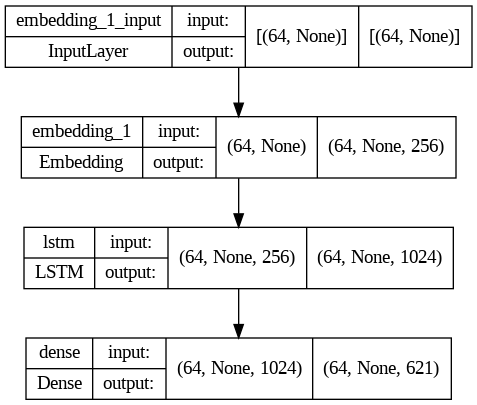

In [31]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

![Model architecture](https://www.tensorflow.org/tutorials/text/images/text_generation_training.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

## Try the model

In [32]:
for input_example_batch, target_example_batch in dataset_sequence_batches.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")


(64, 200, 621) # (batch_size, sequence_length, vocab_size)


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [33]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[ 1.98005256e-03  1.30189303e-03 -8.73610494e-04 -6.45510945e-03
 -2.03021453e-03  1.49506377e-04  4.80862847e-03 -8.26775678e-04
  2.00057402e-04 -1.52451498e-03 -1.86606171e-03  7.76090426e-04
  2.80018523e-03  1.19094062e-03  2.20314972e-03 -3.46394931e-03
 -1.72933680e-03  3.81169561e-03 -8.13993043e-04 -1.03121810e-03
  5.36299660e-04  8.37791886e-04 -1.84840779e-03 -2.24719546e-03
  2.59538973e-03  5.65517810e-04  3.50062316e-03 -2.06428417e-03
 -2.17378000e-03  8.83991597e-05 -1.34971365e-03  1.08261884e-03
 -1.27679855e-03 -1.33991509e-03  1.97165809e-03 -5.52157173e-03
 -5.33057027e-04  2.71222973e-03  1.48885441e-03 -3.82963754e-03
 -2.34074611e-03 -3.75124789e-03  9.51730704e-04 -3.81215615e-03
 -4.52577107e-04 -4.80023213e-03 -2.39485246e-03  1.94002863e-03
  2.36089109e-03 -6.83988328e-04  1.95028522e-04  1.07887795e-03
 -2.36544898e-03  2.13277782e-03 -3.08234780e-03 -3.45403980e-03
  4.95639164e-03  4.67

In [34]:
# Quick overview of how tf.random.categorical() works.

# logits is 2-D Tensor with shape [batch_size, num_classes].
# Each slice [i, :] represents the unnormalized log-probabilities for all classes.
# In the example below we say that the probability for class "0" is low but the
# probability for class "2" is much higher.
tmp_logits = [
  [-0.95, 0, 0.95],
];

# Let's generate 5 samples. Each sample is a class index. Class probabilities
# are being taken into account (we expect to see more samples of class "2").
tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)

print(tmp_samples)

tf.Tensor([[2 2 2 0 1]], shape=(1, 5), dtype=int64)


In [35]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices.shape

TensorShape([200, 1])

In [36]:
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(200,)

In [37]:
sampled_indices

array([393, 257, 416, 428, 112, 105, 414, 417, 330,  28, 512, 507, 394,
       249,  41, 490, 398, 161, 202, 534, 515, 358, 353, 123,   4, 244,
       331, 109, 162, 303, 520,  82,  27, 476, 328, 275, 304, 139, 521,
       202, 303, 468,  31, 129, 549, 390, 368, 298, 231,  75,  71, 346,
       159, 207, 469, 140, 541, 618, 411,   4, 612, 229, 171,  82, 481,
       308,  90, 262,  79, 196, 204, 251, 377, 110, 539, 605, 343, 206,
       158, 574, 155, 535, 482,  25, 500, 160, 438,  86, 108, 564, 269,
       603, 258, 406, 189, 533,   9, 115, 124, 174,  59, 360, 334,  39,
       231, 151, 567, 549, 293, 225, 527, 551, 483, 552, 604, 314,  71,
       467,  17, 483, 245, 283, 130,  58,  19, 583, 409,  67, 235, 544,
       432, 332, 192, 547,  90, 588, 451, 228, 305, 552,  58, 566,  97,
       533, 357, 196, 481, 200, 170,  96, 490, 236,  23, 182, 497, 432,
       421, 265, 564, 619, 157, 517, 266, 514,  15,  41, 502, 362, 534,
       293, 322,  79, 583, 528, 124, 178, 526, 558, 290, 160, 54

In [38]:
print('Input:\n', repr(''.join(index2char[input_example_batch[0]])))
print()
print('Next char prediction:\n', repr(''.join(index2char[sampled_indices])))

Input:
 'udents in Montreal included Robert Savoie. She founded the Opera Guild of Montreal in 1942, serving as president and artistic director until 1969.\n\nIn 1967, she was made an Officer of the Order of Can'

Next char prediction:
 'ḩш€\u3000Ç»″₱ள:局宗ḻрG史ạěΠ日島นณß"лழÁğط庙q9其றלعï延Πط依=å江ზลذУjfกėι俳ñ本ﬂ•"马Пńq勇مyюnɛβтำÅ普録ಲηđ花ć昌務7坪ęゼu¿磨ב里щ’ơ方\'ÍàōYปிEУā维江تЛ探泥化泽野کf会/化мקæX1装†bб板ウவș民y话レОف泽X站£方ธɛ勇˚ł\xa0史в5š國ウ™ј磨）č巴ћ岩-G大พ日تதn装教àś排無اę李♠無!คΙ溪=ŚP排ผmʼ育Íá\tī光'


In [39]:
for i, (input_idx, sample_idx) in enumerate(zip(input_example_batch[0][:5], sampled_indices[:5])):
    print('Prediction #{:1d}'.format(i))
    print('  input: {} ({:s})'.format(input_idx, repr(index2char[input_idx])))
    print('  next predicted: {} ({:s})'.format(target_idx, repr(index2char[sample_idx])))
    print()

Prediction #0
  input: 86 ('u')
  next predicted: 73 ('ḩ')

Prediction #1
  input: 69 ('d')
  next predicted: 73 ('ш')

Prediction #2
  input: 70 ('e')
  next predicted: 73 ('€')

Prediction #3
  input: 79 ('n')
  next predicted: 73 ('\u3000')

Prediction #4
  input: 85 ('t')
  next predicted: 73 ('Ç')



## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

In [40]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 200, 621)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       6.4316344


In [41]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

### Configure checkpoints

In [42]:
# %rm -rf tmp/checkpoints

In [43]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

### Execute the training

In [57]:
EPOCHS=150
STEPS_PER_EPOCH = 10

In [58]:
tmp_dataset = dataset_sequence_batches.repeat()

history = model.fit(
    x=tmp_dataset.as_numpy_iterator(),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[
        checkpoint_callback
    ]
)

Epoch 1/150
10/10 [==============================] - 142s 14s/step - loss: 3.1309
Epoch 2/150
10/10 [==============================] - 131s 13s/step - loss: 3.0330
Epoch 3/150
10/10 [==============================] - 128s 13s/step - loss: 2.9053
Epoch 4/150
10/10 [==============================] - 130s 13s/step - loss: 2.9016
Epoch 5/150
10/10 [==============================] - 131s 13s/step - loss: 2.7955
Epoch 6/150
10/10 [==============================] - 130s 13s/step - loss: 2.7662
Epoch 7/150
10/10 [==============================] - 139s 14s/step - loss: 2.7634
Epoch 8/150
10/10 [==============================] - 135s 14s/step - loss: 2.7220
Epoch 9/150
10/10 [==============================] - 129s 13s/step - loss: 2.6940
Epoch 10/150
10/10 [==============================] - 128s 13s/step - loss: 2.7416
Epoch 11/150
10/10 [==============================] - 127s 13s/step - loss: 2.8991
Epoch 12/150
10/10 [==============================] - 127s 13s/step - loss: 2.6841
Epoch 13/150


In [59]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

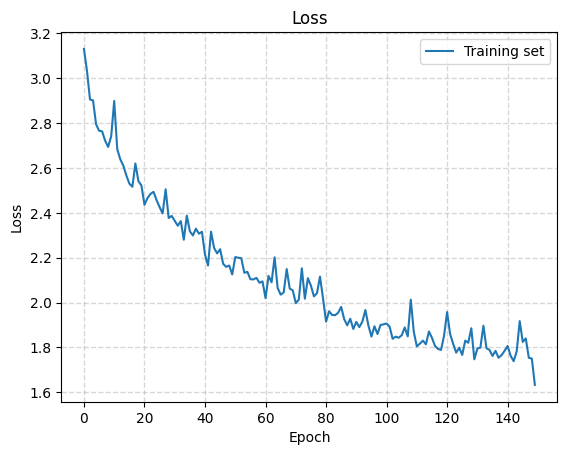

In [60]:
render_training_history(history)

## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.

In [61]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_150'

In [62]:
simplified_batch_size = 1

restored_model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

restored_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

restored_model.build(tf.TensorShape([simplified_batch_size, None]))

In [64]:
restored_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (1, None, 256)            158976    
                                                                 
 lstm_3 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_3 (Dense)             (1, None, 621)            636525    
                                                                 
Total params: 6,042,477
Trainable params: 6,042,477
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

- Get the prediction distribution of the next character using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

![Prediction loop](https://www.tensorflow.org/tutorials/text/images/text_generation_sampling.png)

Image source: [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation) notebook.

In [65]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)

    # Converting our start string to numbers (vectorizing).
    input_indices = [char2index[s] for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
        predictions,
        num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [67]:
num_generate = 300
temperatures = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
start_string = 'Machine learning is'

for temperature in temperatures:
    print("Temperature: {}".format(temperature))
    print('---')
    print(generate_text(restored_model, start_string, num_generate=num_generate, temperature=temperature))
    print('\n')

Temperature: 0.2
---
Machine learning is a series of the competitors of the competition of the program of the first the series of the program and the end of the competitors of the program of the control of the competition of the town of the program of the competitors of the transport of the series of the present of the competitors of the 


Temperature: 0.4
---
Machine learning is entition of the control and the the track of the town the program in the time and the program (born and the carried in 1975 and the took and her competition of the the promation in the Tamo and a resident of the name the transpernation of the competition of the the control of the the first edition 


Temperature: 0.6
---
Machine learning is lost, and 2003 cates, which the close that the program and was an all the first the price the generation of the personal and the charre and were were 10 seconds of the place the definated in a competition of the story of the district of the really carrent in the series, ha

## Save the model

In [69]:
model_name = 'text_generation_wikipedia_rnn.h5'
restored_model.save(model_name, save_format='h5')